In [1]:
import itertools as it
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import ticker
from tqdm.notebook import tqdm
from modelbase.ode import Simulator
from scipy.optimize import minimize

import modelbase

plt.style.use("./notebook.mplstyle")
print(modelbase.__version__)

1.3.5


In [2]:
%%capture
cd ..

In [3]:
from models import get_model

In [4]:
%%capture
cd analyses/

In [5]:
def get_new_y0(s):
    return dict(s.get_results_df().iloc[-1])

# provide starting consitions for the model
y0 = {
    "PQ": 11.027139850905353,
    "PC": 1.8895071932002812,
    "Fd": 3.8690237263896705,
    "ATP": 1.620195002854852,
    "NADPH": 0.4882103700673736,
    "H": 0.0022147075094596015,
    "LHC": 0.8023074419510501,
    "Psbs": 0.9607146039898598,
    "Vx": 0.950783616933656,
    "PGA": 0.9913970817549008,
    "BPGA": 0.0005355311557548053,
    "GAP": 0.0062630116252017295,
    "DHAP": 0.13778623933075737,
    "FBP": 0.006126990841013743,
    "F6P": 0.31166103888161867,
    "G6P": 0.7168203893211117,
    "G1P": 0.041575582577936025,
    "SBP": 0.01311315151803723,
    "S7P": 0.15782894767619207,
    "E4P": 0.00732079113061801,
    "X5P": 0.022396849486562384,
    "R5P": 0.03751472214765548,
    "RUBP": 0.13153657267999222,
    "RU5P": 0.015005888732707041,
    "MDA": 5.85270097771621e-06,
    "ASC": 9.999994138785292,
    "H2O2": 3.4273920330125316e-06,
    "DHA": 8.513863740903352e-09,
    "GSH": 9.999999991725186,
    "GSSG": 4.137406632226743e-09,
    "TR_ox": 0.9,
    "E_inactive": 4.7368421052631575,
}

In [6]:
m = get_model()

In [7]:
# I like to have light as a derived variable
m.add_algebraic_module(
    module_name = "Light",
    function = lambda X, PFD: PFD ,
    compounds = ["PQ"],
    derived_compounds = ["L"],
    parameters = ['pfd'])

In [8]:
def light_simulation(
    s,
    y0,
    high_light=1200,
    low_light=40,
    t_low_light=120,
    t_high_light=30,
    n_light_switches=5,
    t_pre=None,
    t_post=None,
):
    """Start with initial illumination at low light, then
    for n_light_switches
        simulate for t_high_light @ high_light
        simulate for t_low_light @ low_light
    """
    s.initialise(y0)
    s.update_parameter("pfd", low_light)
    if t_pre is None:
        t_end = 0
    else:
        t_end = t_pre
        s.simulate(t_end)
    for _ in tqdm(range(n_light_switches)):
        # High light
        t_end += t_high_light
        s.update_parameter("pfd", high_light)
        s.simulate(t_end)
        # Low light
        t_end += t_low_light
        s.update_parameter("pfd", low_light)
        s.simulate(t_end)
    if t_post is not None:
        t_end += t_post
        s.simulate(t_end)
    return s.get_full_results_df(), s.get_fluxes_df()


def plot_grid(df, items, ncol=3, col_width=4, row_height=3):
    nrow = math.ceil(len(items) / ncol)
    fig, axs = plt.subplots(nrow, ncol, figsize=(col_width * ncol, row_height * nrow))
    for item, ax in zip(items, axs.ravel()):
        try:
            df.loc[:, item].plot(ax=ax)
        except KeyError:
            item = df.columns.intersection(item)
            if len(item) > 0:
                df.loc[
                    :,
                ].plot(ax=ax)
    fig.tight_layout()
    return fig, axs


def shade_light(s, axs):
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]
    lights = [i["pfd"] for i in s.simulation_parameters]
    times = [(i[0], i[-1]) for i in s.time]
    max_pfd = max(lights)
    for ax in np.array(axs).flatten():
        for pfd, (t_start, t_end) in zip(lights, times):
            ax.axvspan(t_start, t_end, color=(0, 0, 0, 1 / 8 * (1 - pfd / max_pfd)))


def annotate_light(s, axs):
    if not isinstance(axs, (list, np.ndarray)):
        axs = [axs]
    lights = [i["pfd"] for i in s.simulation_parameters]
    times = [(i[0], i[-1]) for i in s.time]
    max_pfd = max(lights)
    for ax in np.array(axs).flatten():
        for pfd, (t_start, t_end) in zip(lights, times):
            x = t_start
            #             x = (t_end - t_start) / 2
            #             x, _ = ax.transData.transform((x, 0))
            #             x, _ = ax.transData.inverted().transform((x, 0))
            ax.annotate(str(pfd), (x, 0.1), xycoords="data", ha="left")

# Simplified PAM

In [9]:
s1 = Simulator(m)
s1.initialise(y0)
c1, v1 = light_simulation(
    s1,
    y0,
    high_light=1200,
    low_light=40,
    t_high_light=60,
    t_low_light=60,
    n_light_switches=5,
)

  0%|          | 0/5 [00:00<?, ?it/s]

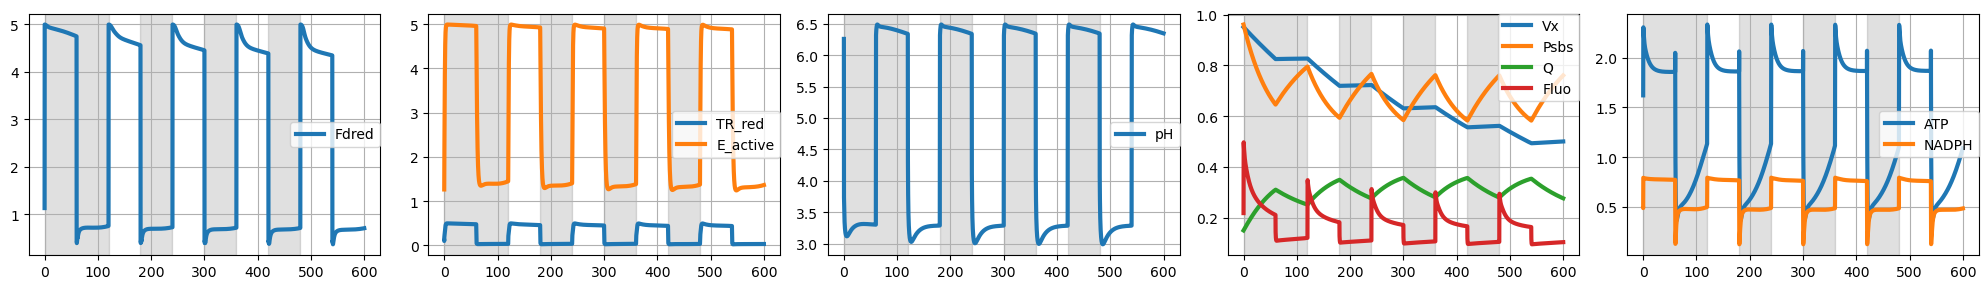

In [17]:
plot_groups = [["Fdred"], ["TR_red", "E_active"], ["pH"], ["Vx", "Psbs", "Q", "Fluo"], ["ATP", "NADPH"]]
fig, axs = plot_grid(c1, plot_groups, ncol=5)
shade_light(s1, axs)
plt.show()

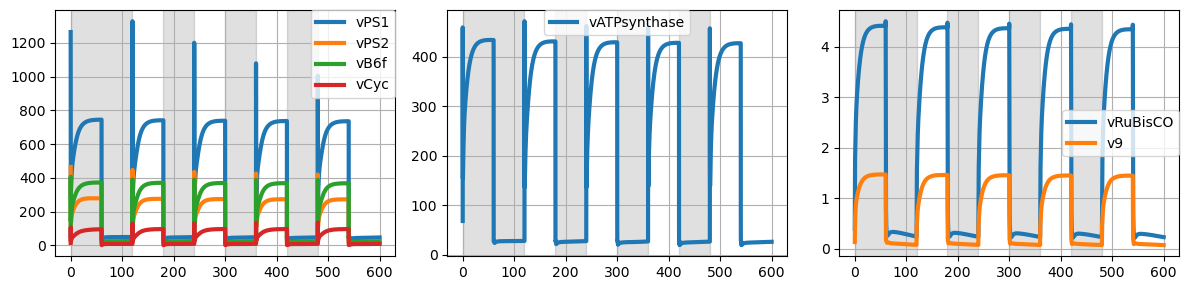

In [14]:
plot_groups = [["vPS1", "vPS2", "vB6f", "vCyc"], ["vATPsynthase"], ["vRuBisCO", "v9"]]
fig, axs = plot_grid(v1, plot_groups, ncol=3)
shade_light(s1, axs)
plt.show()

# Simplified PAM with additional pre and post phases


In [18]:
s1 = Simulator(m)
s1.initialise(y0)
c1, v1 = light_simulation(
     s1,
     y0,
     high_light=1200,
     low_light=50,
     t_high_light=60,
     t_low_light=60,
     n_light_switches=5,
     t_pre=120,
     t_post=600,
)

  0%|          | 0/5 [00:00<?, ?it/s]

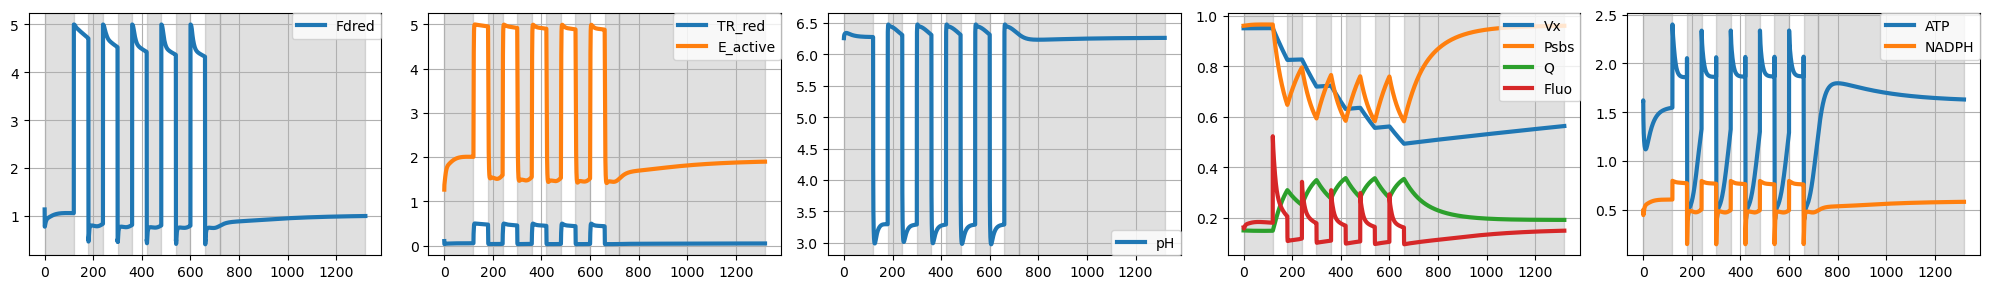

In [19]:
plot_groups = [["Fdred"], ["TR_red", "E_active"], ["pH"], ["Vx", "Psbs", "Q", "Fluo"], ["ATP", "NADPH"]]
fig, axs = plot_grid(c1, plot_groups, ncol=5)
shade_light(s1, axs)
plt.show()

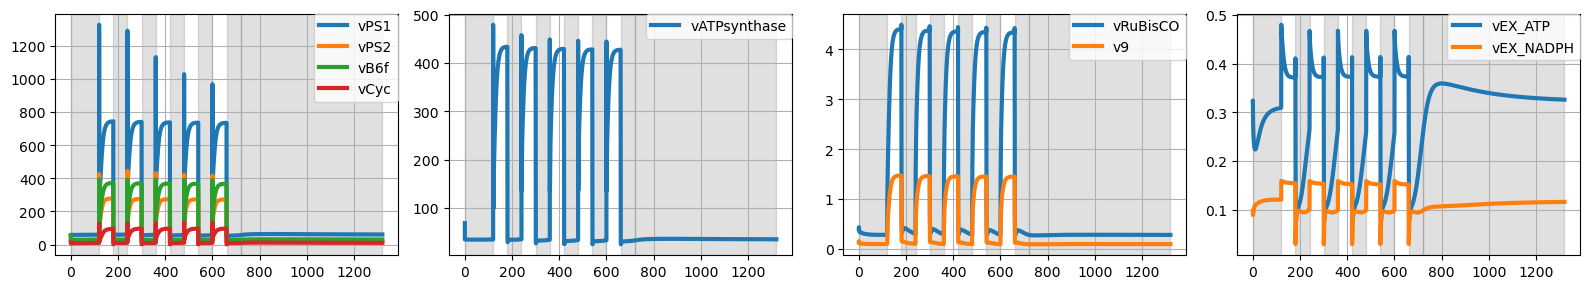

In [20]:
plot_groups = [
    ["vPS1", "vPS2", "vB6f", "vCyc"],
     ["vATPsynthase"],
     ["vRuBisCO", "v9"],
     ["vEX_ATP", "vEX_NADPH"],
 ]
fig, axs = plot_grid(v1, plot_groups, ncol=4)
shade_light(s1, axs)
plt.show()

# PAM

In [21]:
def pam_analysis(
    s, t_relax, t_pulse, pfd_dark, pfd_illumination, pfd_pulse, integrator_kwargs=None
):
    if integrator_kwargs is None:
        integrator_kwargs = {}
    t = it.accumulate(it.chain.from_iterable((t_relax, t_pulse) for i in range(32)))
    pfds = list(
        [pfd_dark, pfd_pulse] * 2
        + [pfd_illumination, pfd_pulse] * 10
        + [pfd_dark, pfd_pulse] * 8
    )
    for t_end, pfd in tqdm(zip(t, pfds), total=len(pfds), desc="simulation"):
        s.update_parameter("pfd", pfd)
        s.simulate(t_end, **integrator_kwargs)


# integrator_kwargs = {"rtol": 1e-10, "atol": 1e-10, "maxnef": 20, "maxncf": 10}

results = {}
pfd_scan = [
    500, 
    # 300, 
    1000,
]
s1 = Simulator(m)
s1.initialise(y0)
for pfd_illumination in tqdm(pfd_scan, total=len(pfd_scan), desc="PFD"):
    s1.clear_results()
    pam_analysis(
        s1,
        t_relax=120,
        t_pulse=0.1,
        pfd_dark=40,
        pfd_illumination=pfd_illumination,
        pfd_pulse=2500,
    )
    results[pfd_illumination] = {
        "conc": s1.get_full_results_df(),
        "flux": s1.get_fluxes_df(),
    }

PFD:   0%|          | 0/2 [00:00<?, ?it/s]

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

simulation:   0%|          | 0/40 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

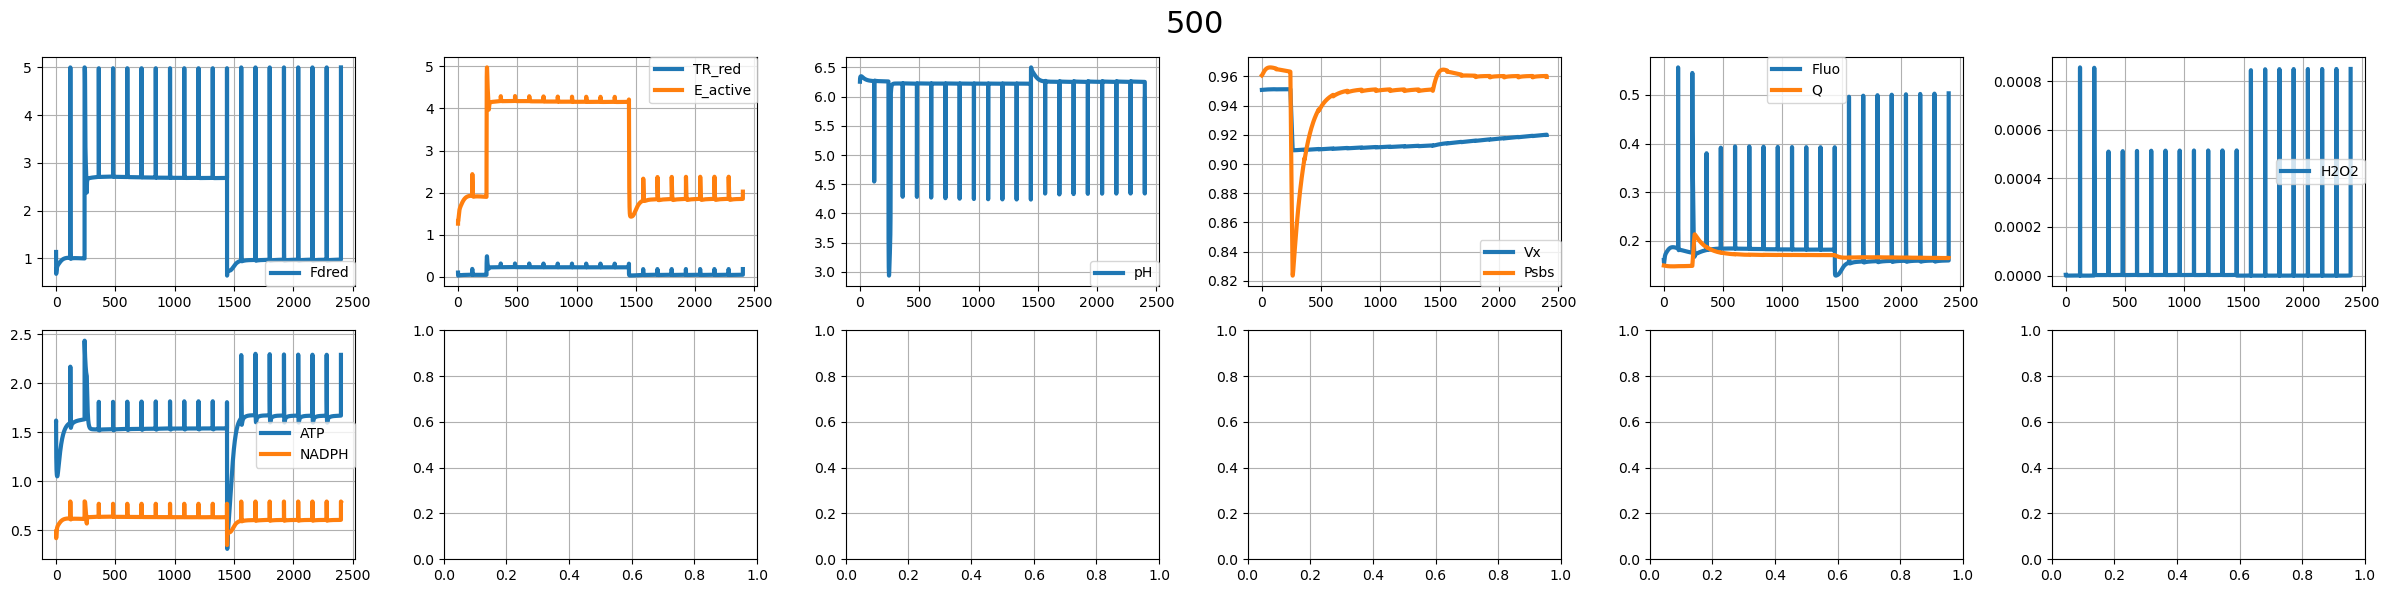

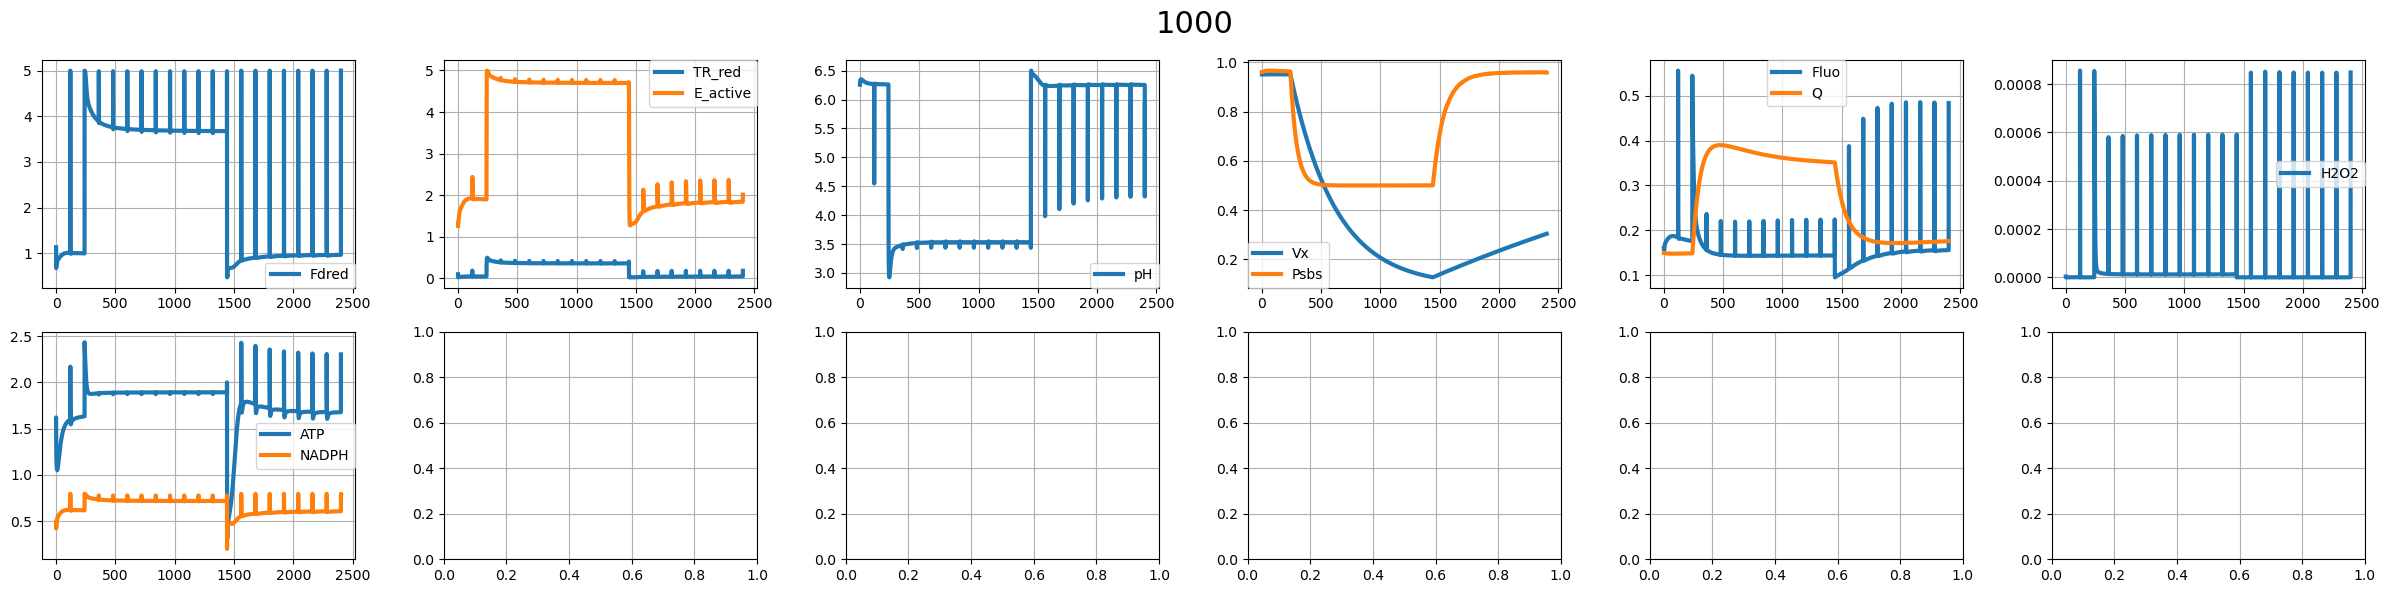

In [25]:
plot_groups = [
    ["Fdred"],
    ["TR_red", "E_active"],
    ["pH"],
    ["Vx", "Psbs"],
    ["Fluo", "Q"],
    ["H2O2"],
    ["ATP", "NADPH"],
]

for pfd, res in results.items():
    fig, axs = plot_grid(res["conc"], plot_groups, ncol=6)
#     shade_light(s1, axs)
    fig.suptitle(pfd)
    fig.tight_layout()
    plt.show()
    shade_light(s1, axs)

plt.savefig("PAManalysis_all.svg", format="svg")

<Figure size 640x480 with 0 Axes>

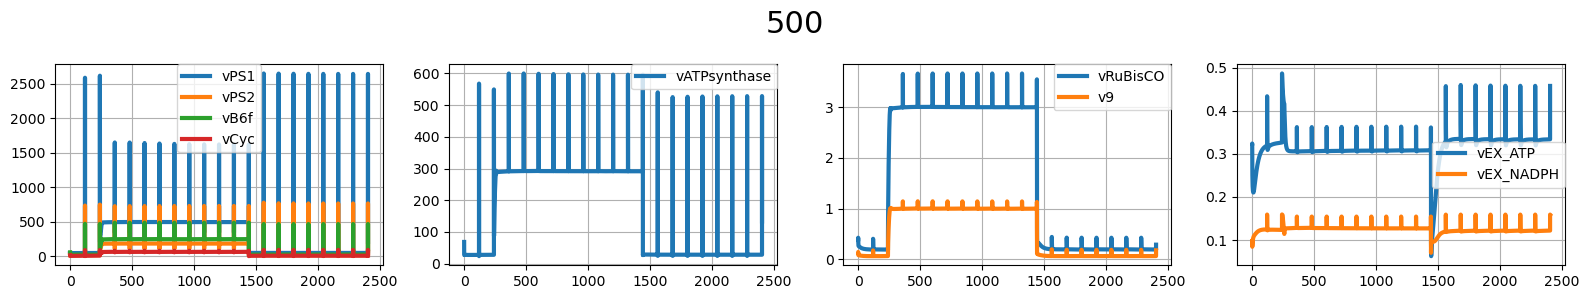

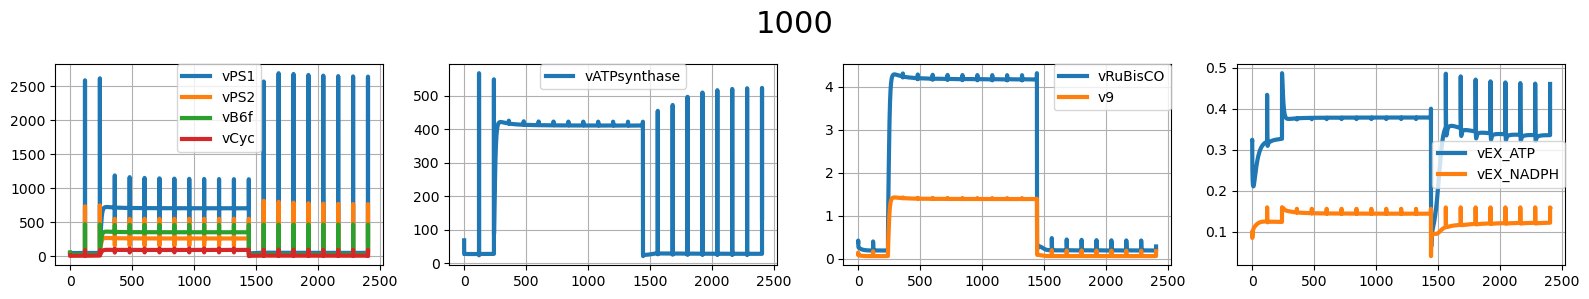

In [23]:
plot_groups = [
    ["vPS1", "vPS2", "vB6f", "vCyc"],
    ["vATPsynthase"],
    ["vRuBisCO", "v9"],
    ["vEX_ATP", "vEX_NADPH"],
]

for pfd, res in results.items():
    fig, axs = plot_grid(res["flux"], plot_groups, ncol=4)
    #     shade_light(s1, axs)
    fig.suptitle(pfd)
    fig.tight_layout()
    plt.show()